# Imports

In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

# Lorenz with noisless sythetic data using FD derivatives

=== SINDy model using FD derivatives on NOISELESS data ===
dx/dt = -0.0285291 - 10.1405*x + 10.0905*y
dy/dt = -0.102319 + 27.7327*x - 0.91462*y + 0.0164634*z - 0.992428*x z
dz/dt = 0.262598 + 0.0916406*x - 0.0497007*y - 2.66128*z + 0.017093*x^2 + 0.978054*x y
Trajectory RMSE (FD, noiseless): 15.950


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (FD, Noiseless) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

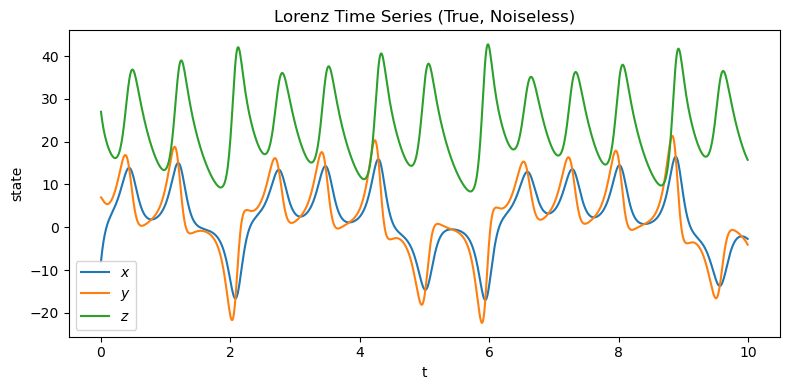

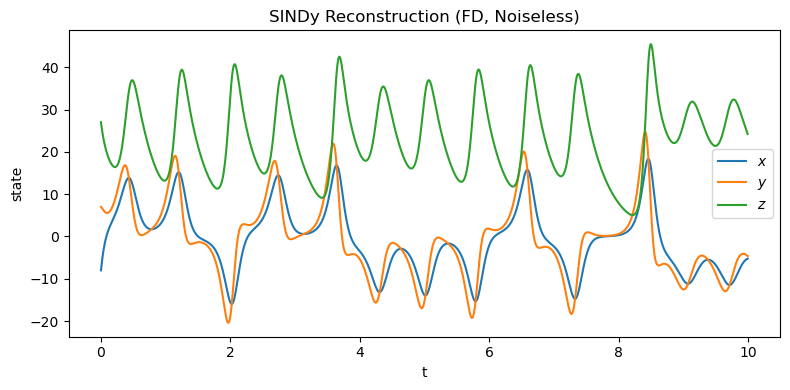

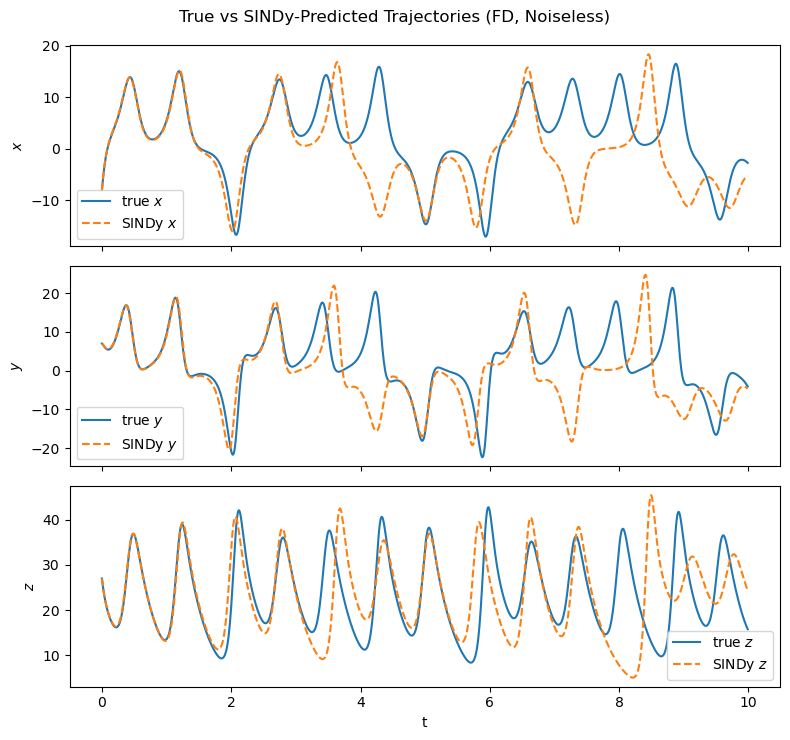

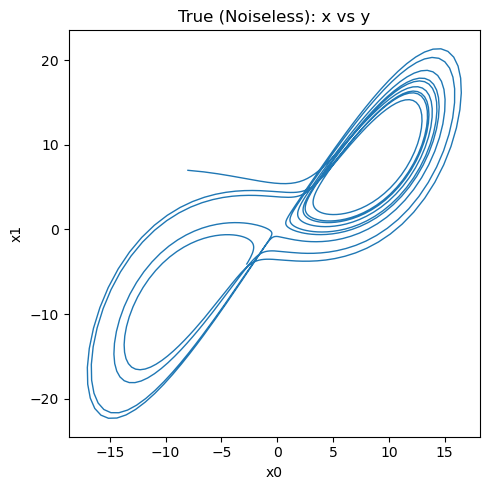

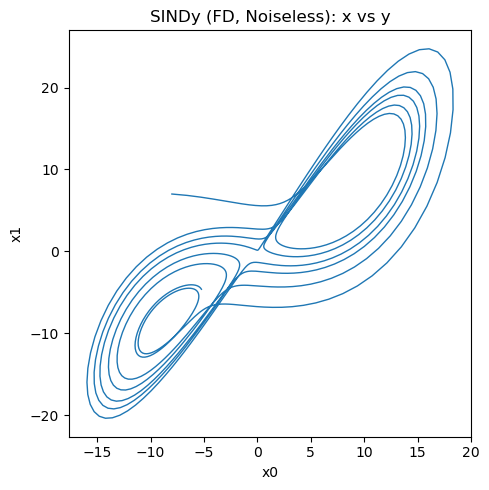

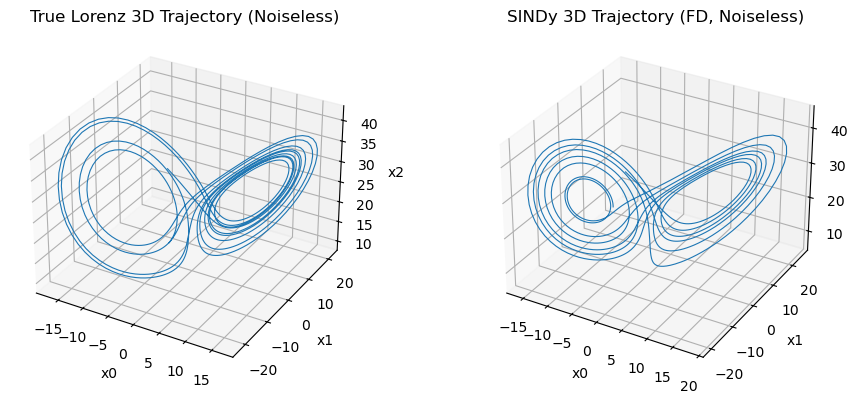

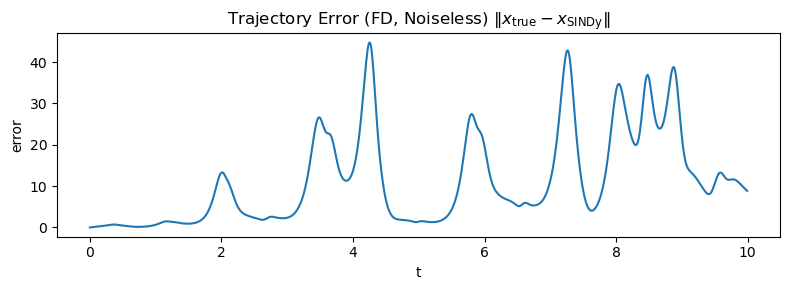

In [3]:
# === Block 1: Lorenz, NOISELESS data, FD derivatives ===

# 1) True Lorenz simulation (no noise)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs = lorenz.simulate()  # ts: (N,), xs: (N, 3)

# 2) FD derivatives on clean data
Xdot_fd = finite_difference_derivative(ts, xs)  # (N, 3)

# Crop ends for SINDy (avoid FD boundary artifacts)
crop = slice(1, -1)
X = xs[crop, :]
Xdot = Xdot_fd[crop, :]

# 3) Fit SINDy (FD, noiseless)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_fd_clean = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using FD derivatives on NOISELESS data ===")
model_fd_clean.print()

# 4) Simulate learned SINDy model and compute trajectory RMSE vs true
x0_true = np.asarray(xs[0, :])
ts_np = np.asarray(ts)

xs_pred = model_fd_clean.simulate(x0_true, ts_np, method="rk4")  # (N, 3)
error_traj = np.linalg.norm(np.asarray(xs) - xs_pred, axis=1)
rmse_traj = np.sqrt(np.mean(error_traj**2))
print(f"Trajectory RMSE (FD, noiseless): {rmse_traj:.3f}")

# 5) Plots (same style as before)
labels = [r"$x$", r"$y$", r"$z$"]

# True time series
plot_time_series(
    ts,
    xs,
    labels=labels,
    title="Lorenz Time Series (True, Noiseless)",
)

# SINDy-predicted time series
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy Reconstruction (FD, Noiseless)",
)

# Overlay comparison
plot_time_series_comparison(
    ts,
    xs,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (FD, Noiseless)",
)

# Phase plots
plot_phase(xs, i=0, j=1, title="True (Noiseless): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (FD, Noiseless): x vs y")

# 3D comparison
plot_3d_comparison(
    xs,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory (Noiseless)",
    title_pred="SINDy 3D Trajectory (FD, Noiseless)",
)

# Error vs time
plot_error_time_series(
    ts,
    error_traj,
    title=r"Trajectory Error (FD, Noiseless) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

# Lorenz with synthetic data + 1% noise using FD derivatives

=== SINDy model using FD derivatives on 1% NOISY data ===
dx/dt = -1.83953 - 10.1293*x + 10.0637*y + 0.216294*z + 0.0292227*x^2 - 0.0283941*x y
dy/dt = -1.66251 + 27.5917*x - 0.864647*y + 0.184518*z + 0.0217829*x^2 - 0.0256412*x y - 0.988522*x z
dz/dt = 1.33869 + 0.0192437*x + 0.0264622*y - 2.80248*z + 0.986101*x y
Trajectory RMSE (FD, 1% noisy data, vs TRUE): 18.979
Trajectory RMSE (FD, 1% noisy data, vs NOISY): 18.983


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (FD, 1% Noisy Fit) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

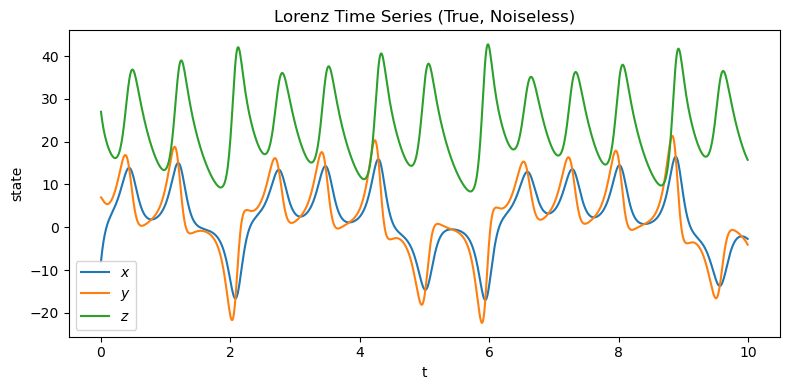

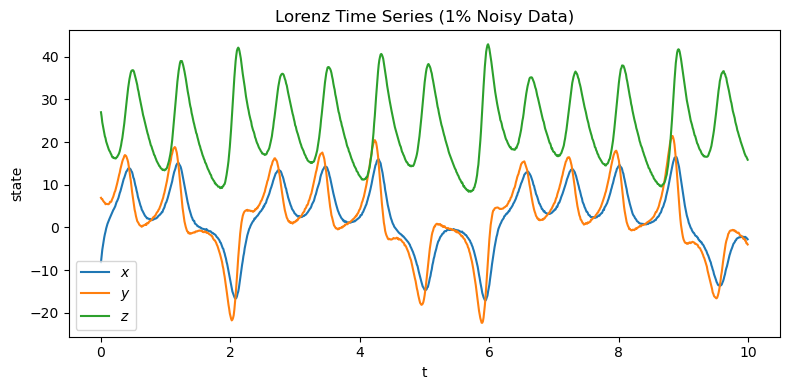

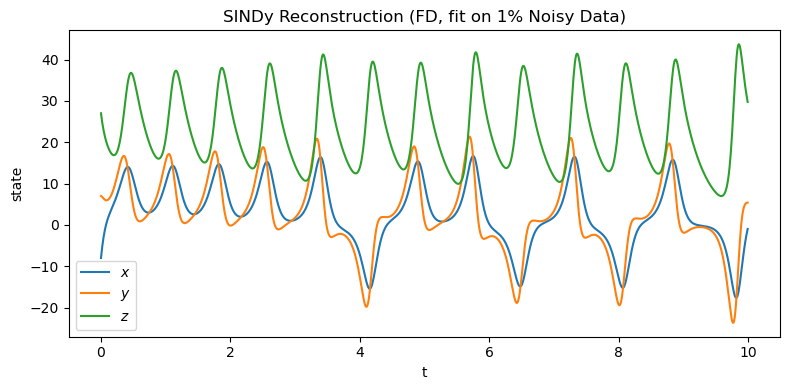

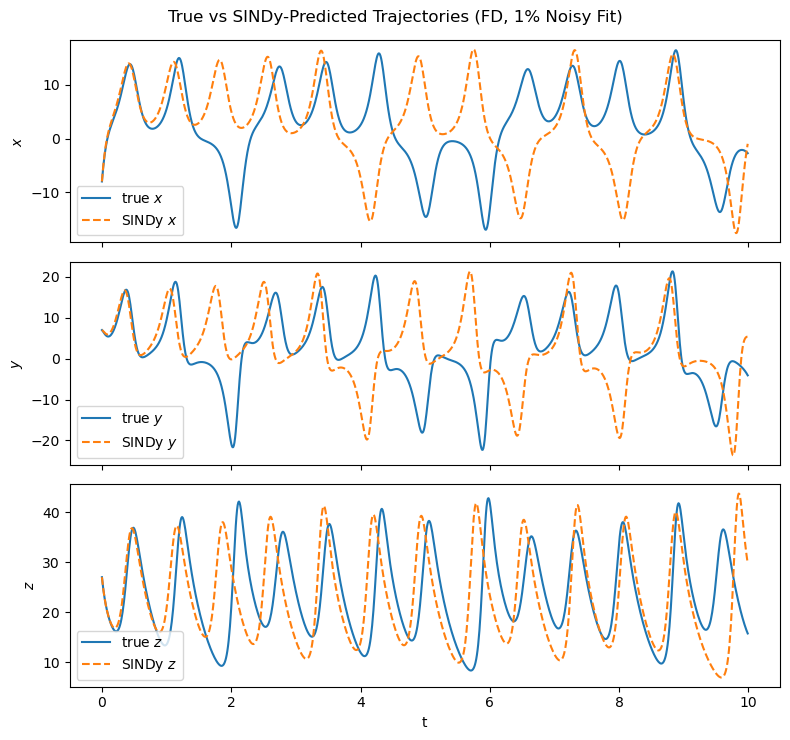

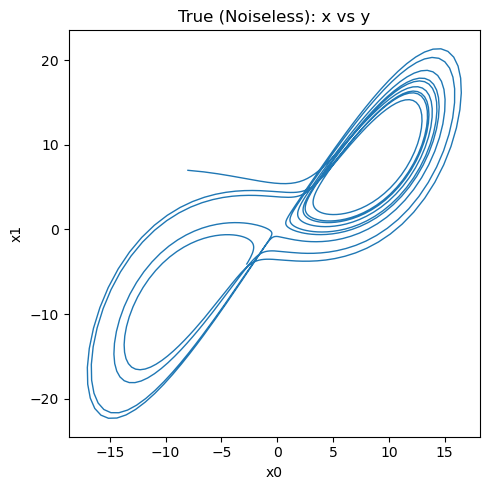

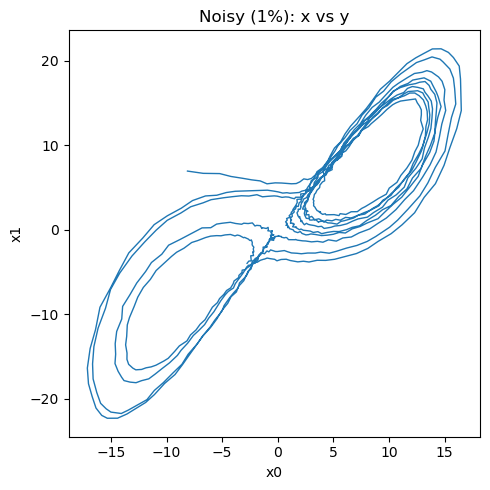

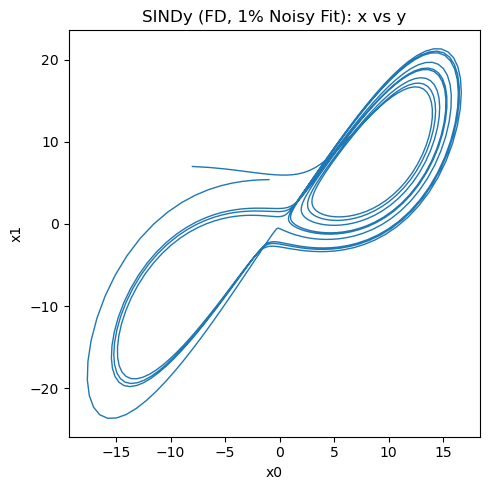

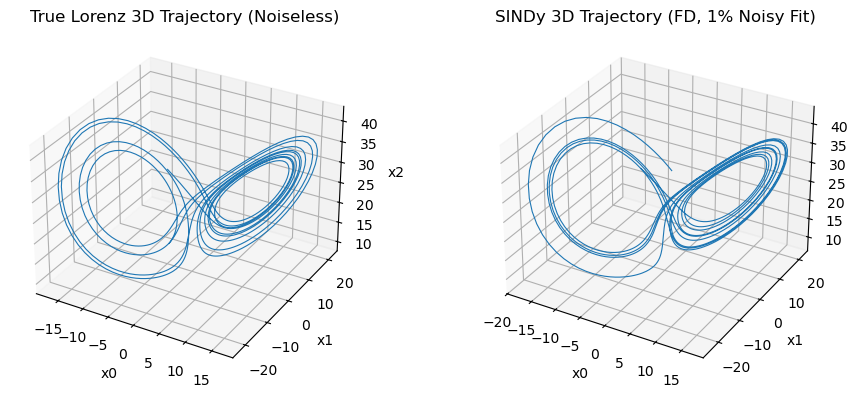

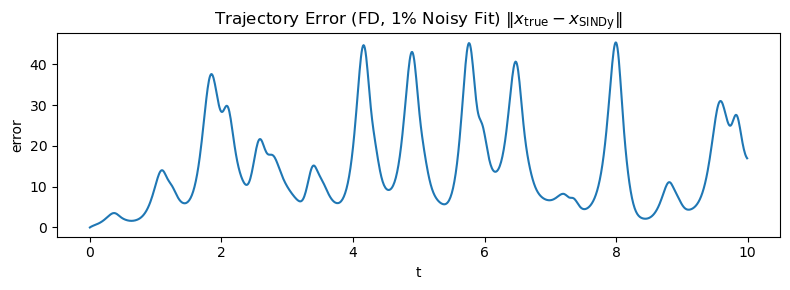

In [4]:
# === Block 2: Lorenz, 1% NOISY data, FD derivatives ===

# 1) True Lorenz simulation (clean, for reference)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs_clean = lorenz.simulate()  # clean reference
ts = jnp.asarray(ts)

# 2) Simulate with 1% relative noise
key = jr.PRNGKey(0)
ts_noisy, xs_noisy = lorenz.simulate_with_noise(noise_pct=0.01, key=key)

# ensure same time grid
assert jnp.allclose(ts, ts_noisy)
xs_noisy = jnp.asarray(xs_noisy)

# 3) FD derivatives on noisy data
Xdot_fd_noisy = finite_difference_derivative(ts, xs_noisy)  # (N, 3)

# Crop ends for SINDy
crop = slice(1, -1)
X = xs_noisy[crop, :]
Xdot = Xdot_fd_noisy[crop, :]

# 4) Fit SINDy (FD, 1% noisy data)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_fd_noisy = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using FD derivatives on 1% NOISY data ===")
model_fd_noisy.print()

# 5) Simulate learned SINDy model and compute trajectory RMSE vs TRUE (clean)
x0_true = np.asarray(xs_clean[0, :])
ts_np = np.asarray(ts)

xs_pred = model_fd_noisy.simulate(x0_true, ts_np, method="rk4")  # (N, 3)
error_traj_true = np.linalg.norm(np.asarray(xs_clean) - xs_pred, axis=1)
rmse_traj_true = np.sqrt(np.mean(error_traj_true**2))
print(f"Trajectory RMSE (FD, 1% noisy data, vs TRUE): {rmse_traj_true:.3f}")

# (optionally, also RMSE vs noisy data)
error_traj_noisy = np.linalg.norm(np.asarray(xs_noisy) - xs_pred, axis=1)
rmse_traj_noisy = np.sqrt(np.mean(error_traj_noisy**2))
print(f"Trajectory RMSE (FD, 1% noisy data, vs NOISY): {rmse_traj_noisy:.3f}")

# 6) Plots (using TRUE trajectory as reference, noisy as observed)

labels = [r"$x$", r"$y$", r"$z$"]

# True vs noisy time series
plot_time_series(
    ts,
    xs_clean,
    labels=labels,
    title="Lorenz Time Series (True, Noiseless)",
)
plot_time_series(
    ts,
    xs_noisy,
    labels=labels,
    title="Lorenz Time Series (1% Noisy Data)",
)

# SINDy-predicted time series
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy Reconstruction (FD, fit on 1% Noisy Data)",
)

# Overlay comparison: TRUE vs SINDy
plot_time_series_comparison(
    ts,
    xs_clean,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (FD, 1% Noisy Fit)",
)

# Phase plots
plot_phase(xs_clean, i=0, j=1, title="True (Noiseless): x vs y")
plot_phase(xs_noisy, i=0, j=1, title="Noisy (1%): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (FD, 1% Noisy Fit): x vs y")

# 3D comparison (TRUE vs SINDy)
plot_3d_comparison(
    xs_clean,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory (Noiseless)",
    title_pred="SINDy 3D Trajectory (FD, 1% Noisy Fit)",
)

# Error vs time (vs TRUE)
plot_error_time_series(
    ts,
    error_traj_true,
    title=r"Trajectory Error (FD, 1% Noisy Fit) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

# Lorenz with sythetic data and SG derivatives

=== SINDy model using SG derivatives on NOISELESS data ===
dx/dt = 1.1027 - 11.0152*x + 10.7018*y - 0.128735*z - 0.0197379*x^2 + 0.0196479*x y + 0.0321556*x z - 0.0246844*y z
dy/dt = 0.304747 + 26.3923*x - 0.445385*y - 0.0153467*z - 0.0154616*x^2 + 0.0175654*x y - 0.956034*x z
dz/dt = -3.90923 + 0.788507*x - 0.482611*y - 1.91244*z + 0.225359*x^2 + 0.763482*x y - 0.0204614*x z + 0.0583749*y^2 + 0.0127262*y z - 0.0288789*z^2
Trajectory RMSE (SG, noiseless): 12.986


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (SG, Noiseless) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

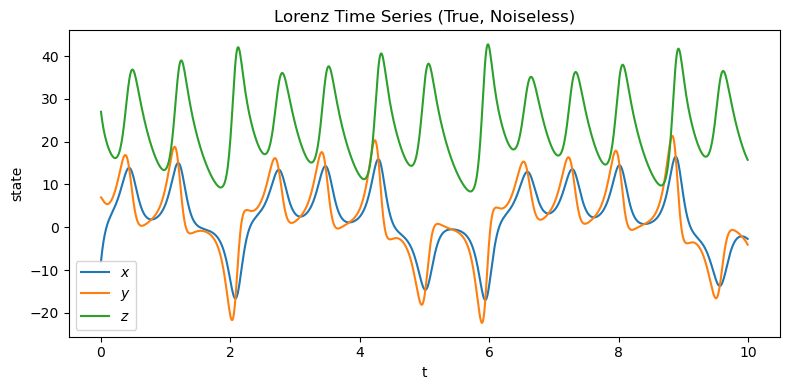

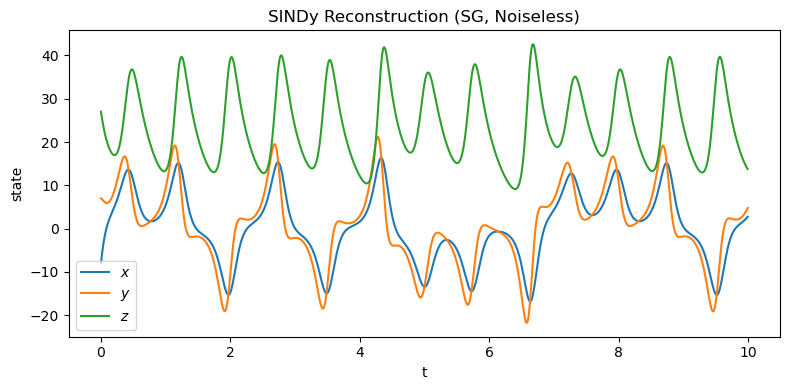

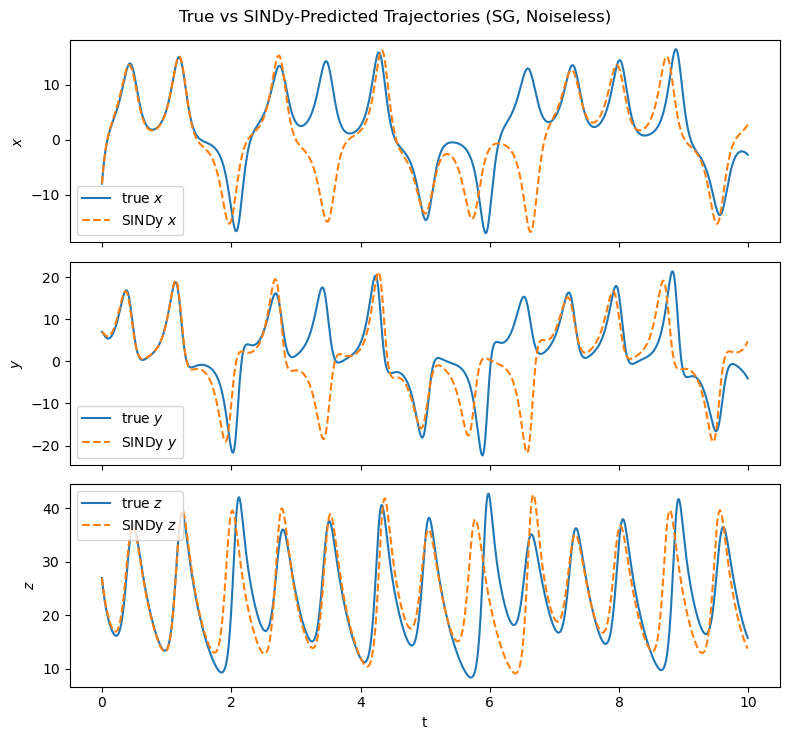

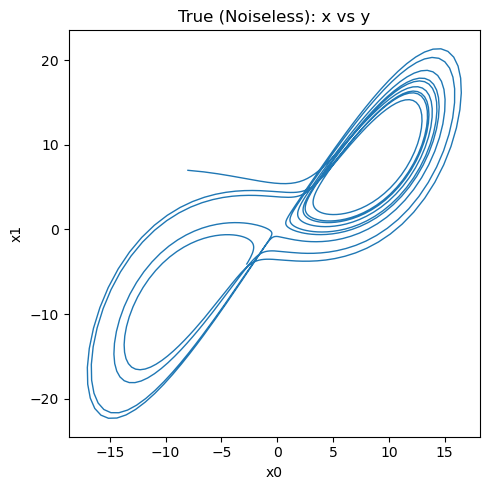

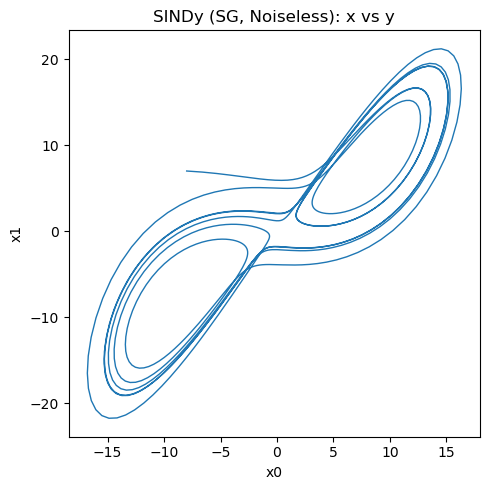

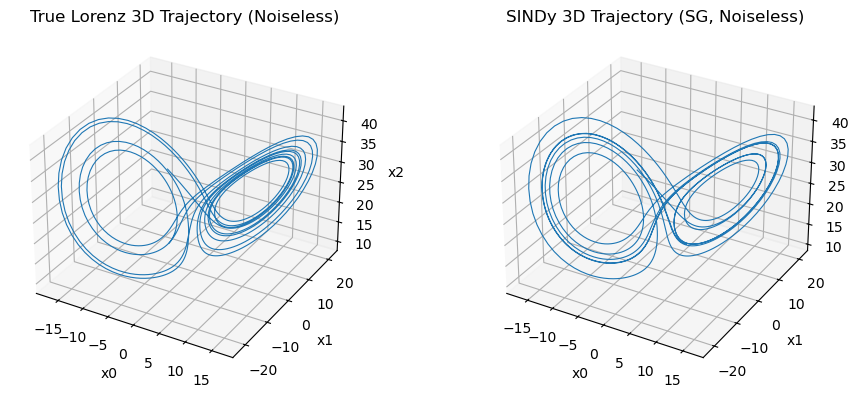

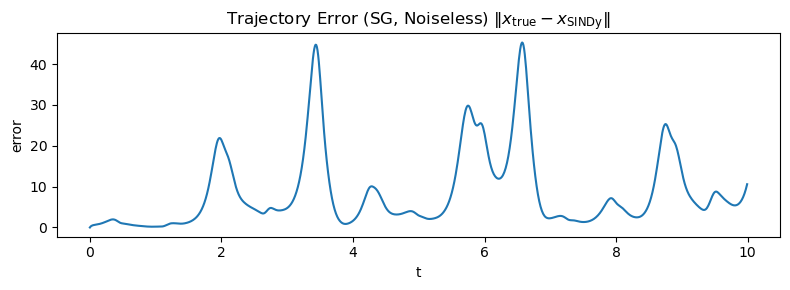

In [2]:
# === Block 3: Lorenz, NOISELESS data, SG derivatives ===

# 1) True Lorenz simulation (no noise)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs = lorenz.simulate()  # ts: (N,), xs: (N, 3)

# 2) SG derivatives on clean data
# (for consistency, use same window as noisy case; you could also use a smaller one)
Xdot_sg = sgolay_derivative(ts, xs, window_length=21, polyorder=3)  # (N, 3)

# Crop ends for SINDy
crop = slice(1, -1)
X = xs[crop, :]
Xdot = Xdot_sg[crop, :]

# 3) Fit SINDy (SG, noiseless)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_sg_clean = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using SG derivatives on NOISELESS data ===")
model_sg_clean.print()

# 4) Simulate learned SINDy model and compute trajectory RMSE vs true
x0_true = np.asarray(xs[0, :])
ts_np = np.asarray(ts)

xs_pred = model_sg_clean.simulate(x0_true, ts_np, method="rk4")  # (N, 3)
error_traj = np.linalg.norm(np.asarray(xs) - xs_pred, axis=1)
rmse_traj = np.sqrt(np.mean(error_traj**2))
print(f"Trajectory RMSE (SG, noiseless): {rmse_traj:.3f}")

# 5) Plots (same style as FD block)

labels = [r"$x$", r"$y$", r"$z$"]

# True time series
plot_time_series(
    ts,
    xs,
    labels=labels,
    title="Lorenz Time Series (True, Noiseless)",
)

# SINDy-predicted time series (SG)
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy Reconstruction (SG, Noiseless)",
)

# Overlay comparison
plot_time_series_comparison(
    ts,
    xs,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (SG, Noiseless)",
)

# Phase plots
plot_phase(xs, i=0, j=1, title="True (Noiseless): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (SG, Noiseless): x vs y")

# 3D comparison
plot_3d_comparison(
    xs,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory (Noiseless)",
    title_pred="SINDy 3D Trajectory (SG, Noiseless)",
)

# Error vs time
plot_error_time_series(
    ts,
    error_traj,
    title=r"Trajectory Error (SG, Noiseless) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

# Lorenz with synthetic data + 1% noise and SG derivatives

=== SINDy model using SG derivatives on 1% NOISY data ===
dx/dt = -0.119423 - 10.9766*x + 10.6646*y + 0.0145614*z + 0.0315406*x z - 0.0236602*y z
dy/dt = -1.25934 + 26.2885*x - 0.412893*y + 0.159356*z - 0.953078*x z - 0.0104733*y z
dz/dt = -2.67532 + 0.638295*x - 0.358983*y - 2.07663*z + 0.204984*x^2 + 0.775904*x y - 0.0161471*x z + 0.058629*y^2 - 0.0240064*z^2
Trajectory RMSE (SG, 1% noisy data, vs TRUE): 16.565
Trajectory RMSE (SG, 1% noisy data, vs NOISY): 16.571


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (SG, 1% Noisy Fit) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

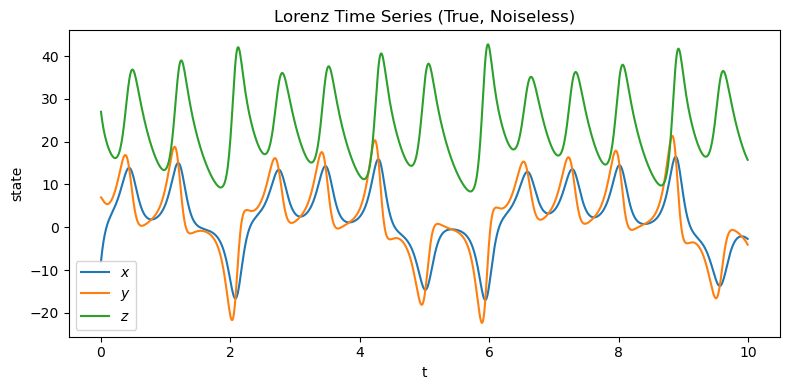

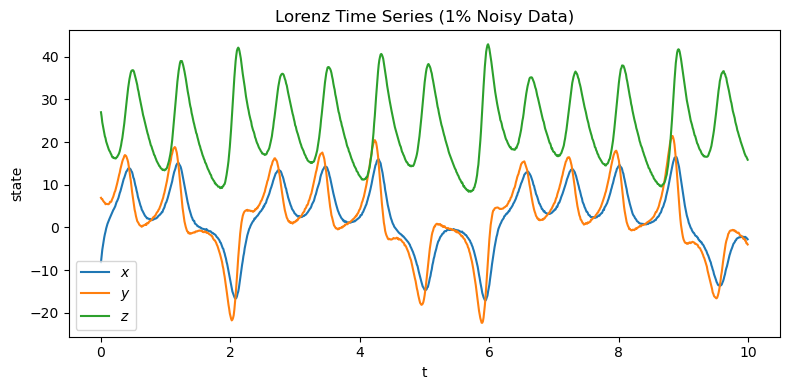

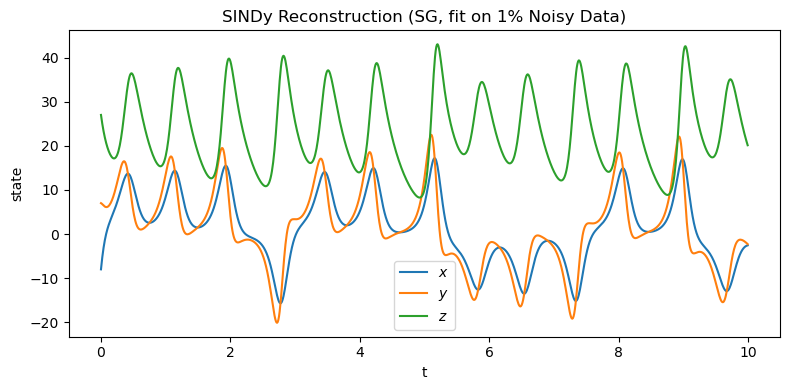

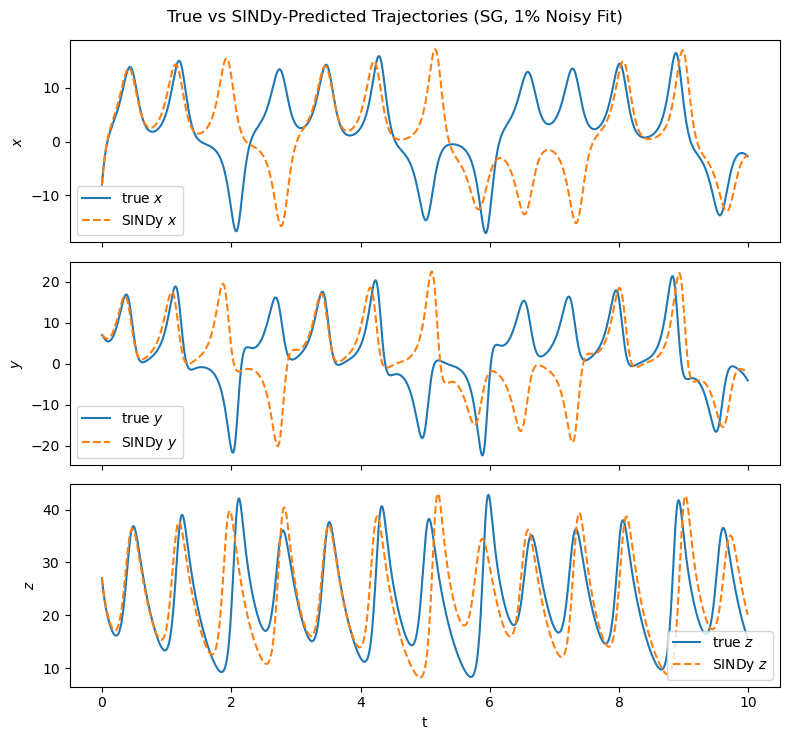

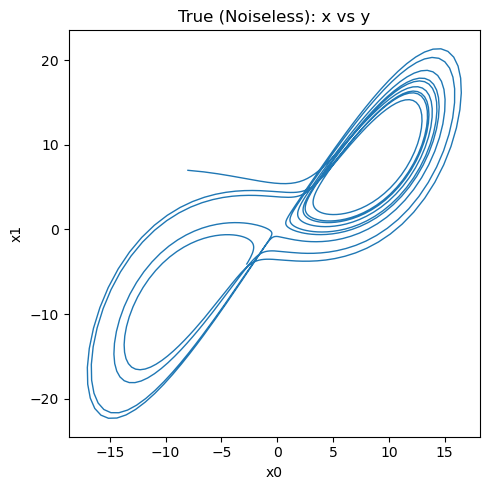

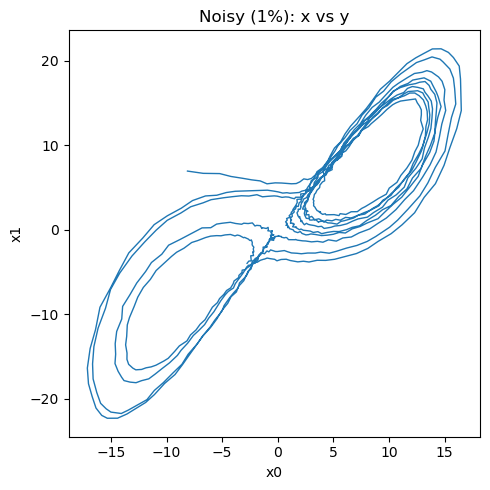

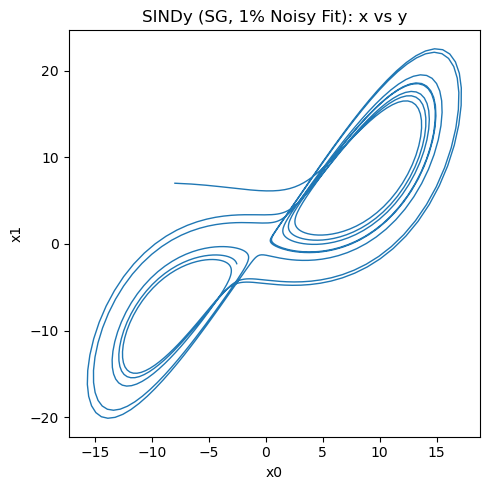

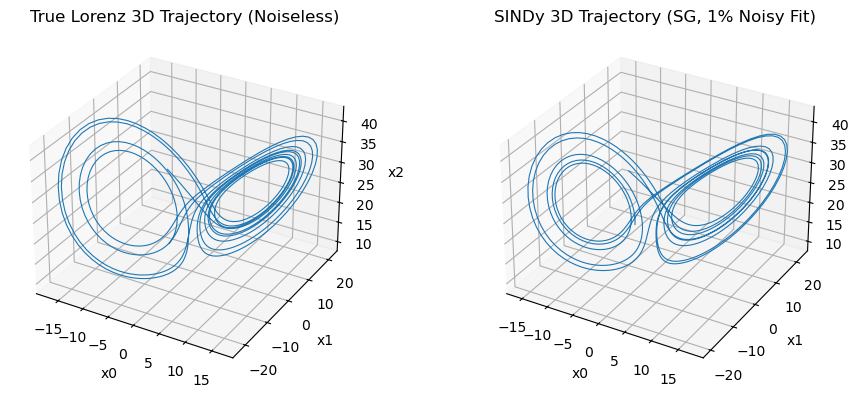

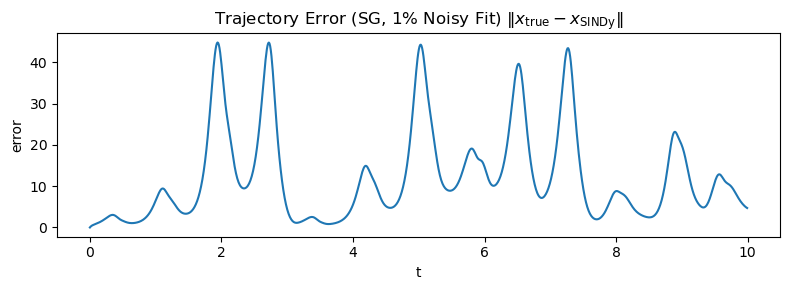

In [3]:
# === Block 4: Lorenz, 1% NOISY data, SG derivatives ===

# 1) True Lorenz simulation (clean, for reference)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs_clean = lorenz.simulate()  # clean reference
ts = jnp.asarray(ts)

# 2) Simulate with 1% relative noise
key = jr.PRNGKey(0)
ts_noisy, xs_noisy = lorenz.simulate_with_noise(noise_pct=0.01, key=key)

# ensure same time grid
assert jnp.allclose(ts, ts_noisy)
xs_noisy = jnp.asarray(xs_noisy)

# 3) SG derivatives on noisy data (tuned window_length=21)
Xdot_sg_noisy = sgolay_derivative(
    ts, xs_noisy, window_length=21, polyorder=3
)  # (N, 3)

# Crop ends for SINDy
crop = slice(1, -1)
X = xs_noisy[crop, :]
Xdot = Xdot_sg_noisy[crop, :]

# 4) Fit SINDy (SG, 1% noisy data)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_sg_noisy = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using SG derivatives on 1% NOISY data ===")
model_sg_noisy.print()

# 5) Simulate learned SINDy model and compute trajectory RMSE vs TRUE (clean)
x0_true = np.asarray(xs_clean[0, :])
ts_np = np.asarray(ts)

xs_pred = model_sg_noisy.simulate(x0_true, ts_np, method="rk4")  # (N, 3)
error_traj_true = np.linalg.norm(np.asarray(xs_clean) - xs_pred, axis=1)
rmse_traj_true = np.sqrt(np.mean(error_traj_true**2))
print(f"Trajectory RMSE (SG, 1% noisy data, vs TRUE): {rmse_traj_true:.3f}")

# (optionally, also RMSE vs noisy data)
error_traj_noisy = np.linalg.norm(np.asarray(xs_noisy) - xs_pred, axis=1)
rmse_traj_noisy = np.sqrt(np.mean(error_traj_noisy**2))
print(f"Trajectory RMSE (SG, 1% noisy data, vs NOISY): {rmse_traj_noisy:.3f}")

# 6) Plots

labels = [r"$x$", r"$y$", r"$z$"]

# True vs noisy time series
plot_time_series(
    ts,
    xs_clean,
    labels=labels,
    title="Lorenz Time Series (True, Noiseless)",
)
plot_time_series(
    ts,
    xs_noisy,
    labels=labels,
    title="Lorenz Time Series (1% Noisy Data)",
)

# SINDy-predicted time series (SG model)
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy Reconstruction (SG, fit on 1% Noisy Data)",
)

# Overlay comparison: TRUE vs SINDy
plot_time_series_comparison(
    ts,
    xs_clean,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (SG, 1% Noisy Fit)",
)

# Phase plots
plot_phase(xs_clean, i=0, j=1, title="True (Noiseless): x vs y")
plot_phase(xs_noisy, i=0, j=1, title="Noisy (1%): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (SG, 1% Noisy Fit): x vs y")

# 3D comparison (TRUE vs SINDy)
plot_3d_comparison(
    xs_clean,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory (Noiseless)",
    title_pred="SINDy 3D Trajectory (SG, 1% Noisy Fit)",
)

# Error vs time (vs TRUE)
plot_error_time_series(
    ts,
    error_traj_true,
    title=r"Trajectory Error (SG, 1% Noisy Fit) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

# Lorenz with synthetic data using TV derivatives

=== SINDy model using TV derivatives on NOISELESS data ===
dx/dt = 7.28509 - 11.5688*x + 10.4161*y - 0.897884*z - 0.124666*x^2 + 0.117915*x y + 0.0431509*x z - 0.0270342*y^2 + 0.0260595*z^2
dy/dt = -0.208985 + 29.6462*x - 2.87609*y - 1.07298*x z + 0.0979169*y z
dz/dt = -2.03986 - 0.720451*x + 0.390281*y - 2.42699*z + 0.132569*x^2 + 1.01997*x y + 0.0168803*x z - 0.0823153*y^2
Trajectory RMSE (TV, noiseless): 22.571


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (TV, Noiseless) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

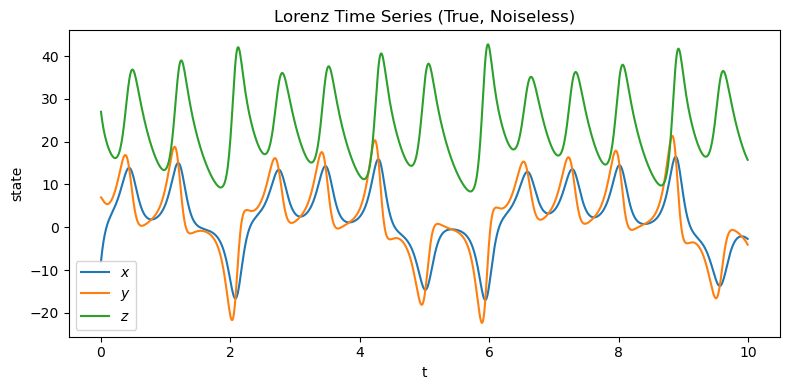

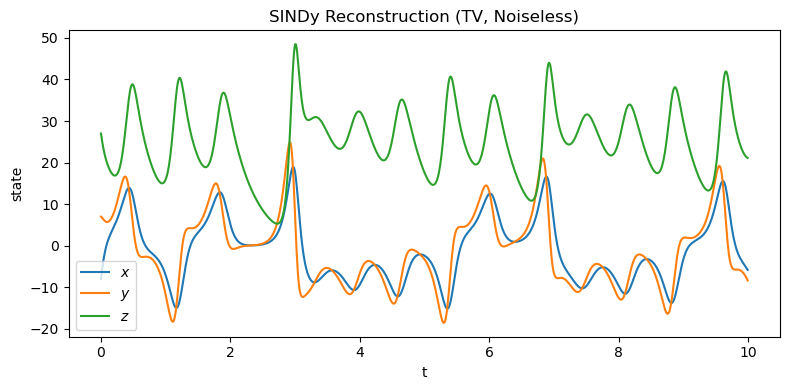

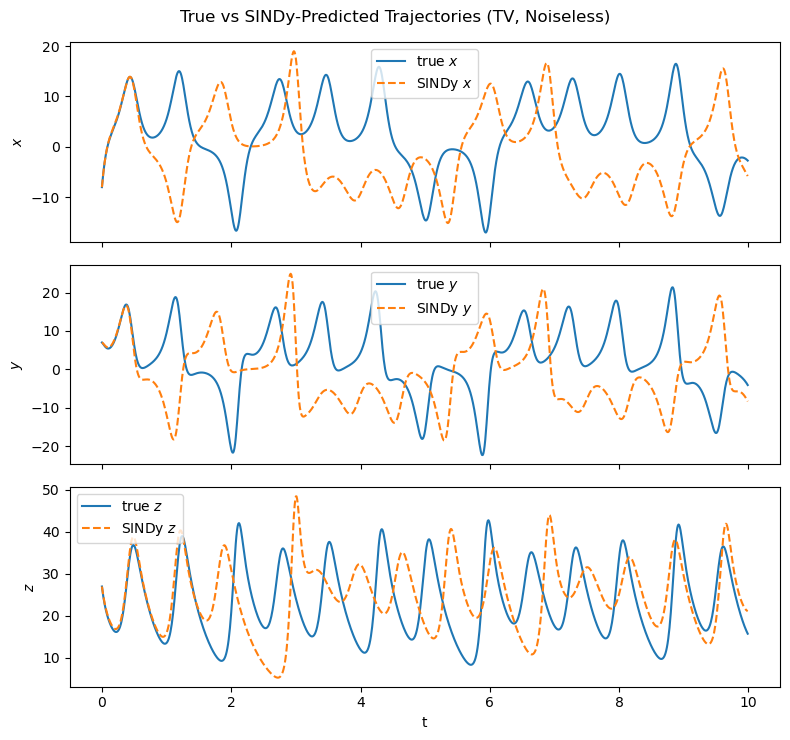

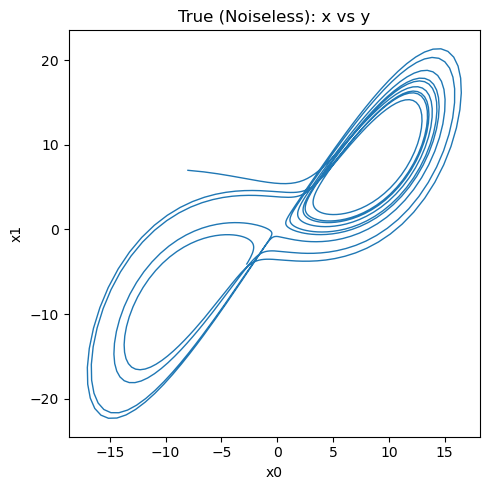

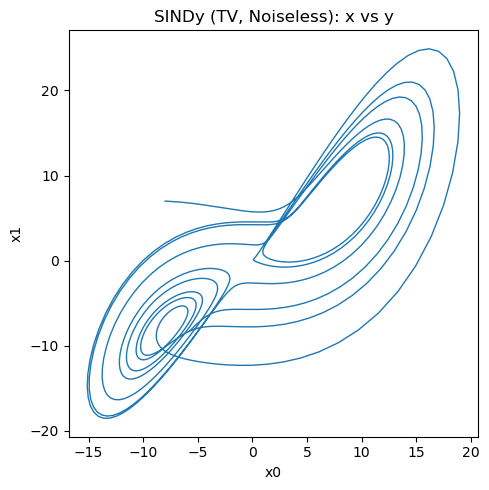

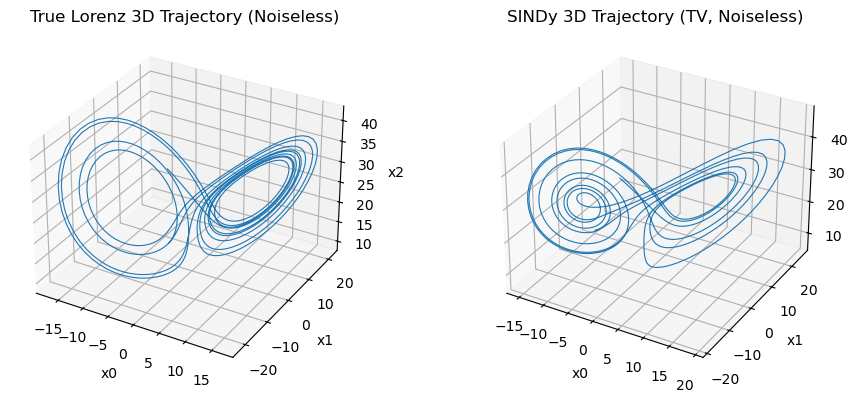

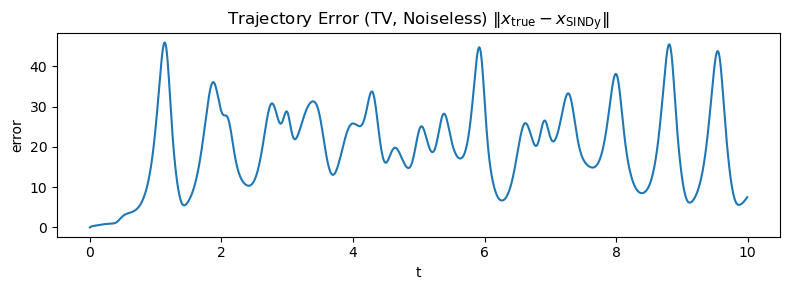

In [4]:
# === Block 5: Lorenz, NOISELESS data, TV derivatives ===

# 1) True Lorenz simulation (no noise)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs = lorenz.simulate()  # ts: (N,), xs: (N, 3)

# 2) TV derivatives on clean data (use tuned-ish alpha)
Xdot_tv = tv_derivative(ts, xs, alpha=5e-5, n_iters=20)  # (N, 3)

# Crop ends for SINDy
crop = slice(1, -1)
X = xs[crop, :]
Xdot = Xdot_tv[crop, :]

# 3) Fit SINDy (TV, noiseless)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_tv_clean = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using TV derivatives on NOISELESS data ===")
model_tv_clean.print()

# 4) Simulate learned SINDy model and compute trajectory RMSE vs true
x0_true = np.asarray(xs[0, :])
ts_np = np.asarray(ts)

xs_pred = model_tv_clean.simulate(x0_true, ts_np, method="rk4")  # (N, 3)
error_traj = np.linalg.norm(np.asarray(xs) - xs_pred, axis=1)
rmse_traj = np.sqrt(np.mean(error_traj**2))
print(f"Trajectory RMSE (TV, noiseless): {rmse_traj:.3f}")

# 5) Plots

labels = [r"$x$", r"$y$", r"$z$"]

# True time series
plot_time_series(
    ts,
    xs,
    labels=labels,
    title="Lorenz Time Series (True, Noiseless)",
)

# SINDy-predicted time series (TV)
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy Reconstruction (TV, Noiseless)",
)

# Overlay comparison
plot_time_series_comparison(
    ts,
    xs,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (TV, Noiseless)",
)

# Phase plots
plot_phase(xs, i=0, j=1, title="True (Noiseless): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (TV, Noiseless): x vs y")

# 3D comparison
plot_3d_comparison(
    xs,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory (Noiseless)",
    title_pred="SINDy 3D Trajectory (TV, Noiseless)",
)

# Error vs time
plot_error_time_series(
    ts,
    error_traj,
    title=r"Trajectory Error (TV, Noiseless) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

# Lorenz with synthetic data + 1% noise and TV derivatives

=== SINDy model using TV derivatives on 1% NOISY data ===
dx/dt = 5.81766 - 11.4912*x + 10.3573*y - 0.724051*z - 0.101343*x^2 + 0.0975898*x y + 0.0415993*x z - 0.0226073*y^2 + 0.0209249*z^2
dy/dt = -0.639751 + 29.4539*x - 2.78419*y + 0.0183715*z - 1.06762*x z + 0.0953811*y z
dz/dt = -0.541968 - 0.855348*x + 0.503751*y - 2.62955*z + 0.107638*x^2 + 1.03417*x y + 0.0206818*x z - 0.0813481*y^2 - 0.0121572*y z
Trajectory RMSE (TV, 1% noisy, vs TRUE): 18.551
Trajectory RMSE (TV, 1% noisy, vs NOISY): 18.555


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error (TV, 1% noisy fit) $\\|x_{\\rm true} - x_{\\rm SINDy}\\|$'}, xlabel='t', ylabel='error'>)

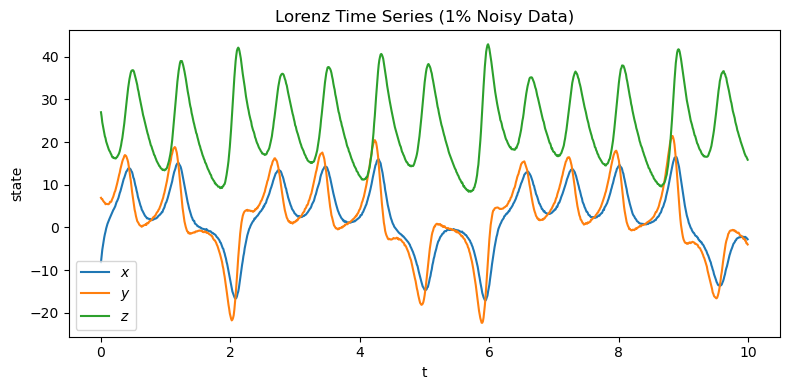

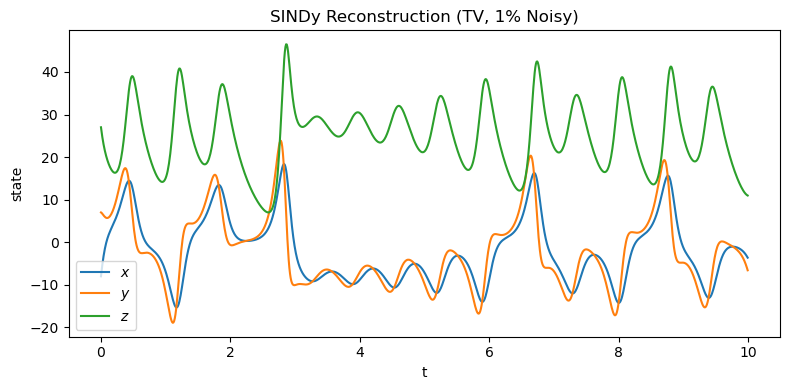

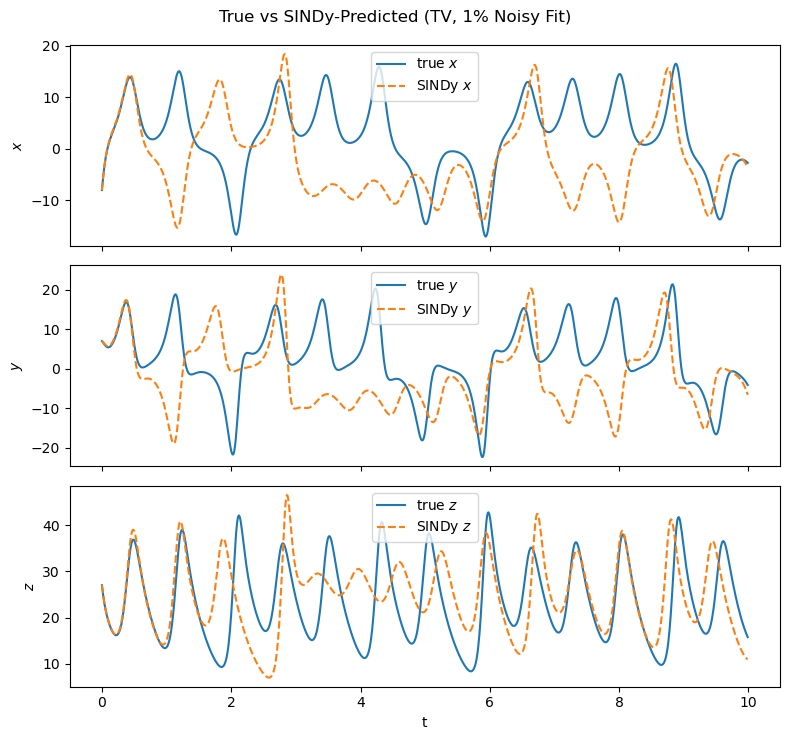

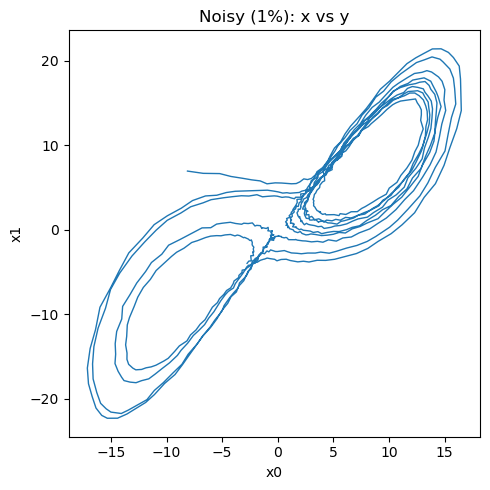

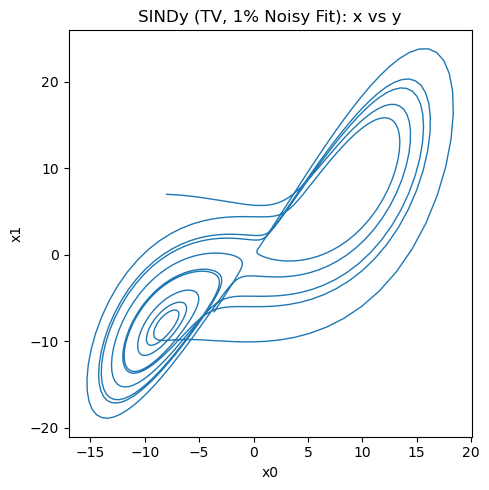

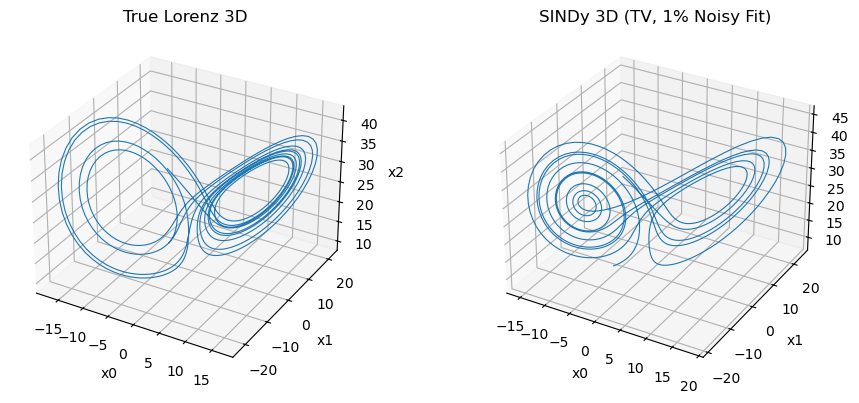

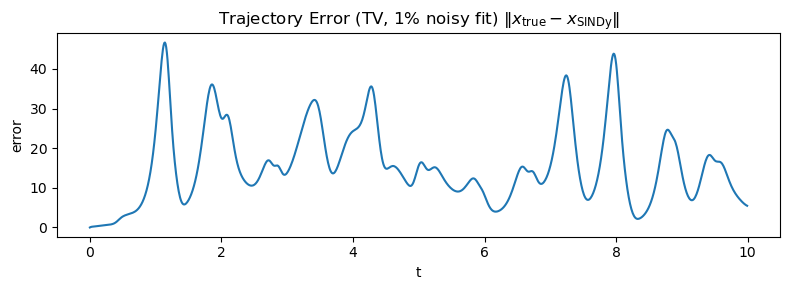

In [5]:
# === Block 6: Lorenz, 1% NOISY data, TV derivatives ===

# 1) True Lorenz simulation (for comparison)
lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs_clean = lorenz.simulate()  # noiseless reference
ts = jnp.asarray(ts)

# 2) Generate 1% noisy data
key = jr.PRNGKey(0)
_, xs_noisy = lorenz.simulate_with_noise(noise_pct=0.01, key=key)
xs_noisy = jnp.asarray(xs_noisy)

# 3) TV derivatives on noisy data
# alpha chosen from tuning sweep (moderate smoothing)
Xdot_tv_noisy = tv_derivative(ts, xs_noisy, alpha=5e-5, n_iters=20)

# Crop edges for SINDy
crop = slice(1, -1)
X = xs_noisy[crop, :]
Xdot = Xdot_tv_noisy[crop, :]

# 4) Fit SINDy (TV, 1% noisy data)
cfg = SINDyConfig(
    poly_degree=2,
    include_bias=True,
    threshold=0.5,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model_tv_noisy = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using TV derivatives on 1% NOISY data ===")
model_tv_noisy.print()

# 5) Simulate learned SINDy model
x0_true = np.asarray(xs_clean[0, :])
ts_np = np.asarray(ts)

xs_pred = model_tv_noisy.simulate(x0_true, ts_np, method="rk4")

# RMSE vs TRUE clean trajectory
error_traj = np.linalg.norm(np.asarray(xs_clean) - xs_pred, axis=1)
rmse_true = np.sqrt(np.mean(error_traj**2))
print(f"Trajectory RMSE (TV, 1% noisy, vs TRUE): {rmse_true:.3f}")

# Optional: RMSE vs noisy data
error_traj_noisy = np.linalg.norm(np.asarray(xs_noisy) - xs_pred, axis=1)
rmse_noisy = np.sqrt(np.mean(error_traj_noisy**2))
print(f"Trajectory RMSE (TV, 1% noisy, vs NOISY): {rmse_noisy:.3f}")

# 6) Plots

labels = [r"$x$", r"$y$", r"$z$"]

# --- Time series ---
plot_time_series(
    ts, xs_noisy, labels=labels, title="Lorenz Time Series (1% Noisy Data)"
)
plot_time_series(
    ts, xs_pred, labels=labels, title="SINDy Reconstruction (TV, 1% Noisy)"
)

# --- Overlay vs TRUE ---
plot_time_series_comparison(
    ts,
    xs_clean,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted (TV, 1% Noisy Fit)",
)

# --- Phase portraits ---
plot_phase(xs_noisy, i=0, j=1, title="Noisy (1%): x vs y")
plot_phase(xs_pred, i=0, j=1, title="SINDy (TV, 1% Noisy Fit): x vs y")

# --- 3D comparison ---
plot_3d_comparison(
    xs_clean,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D",
    title_pred="SINDy 3D (TV, 1% Noisy Fit)",
)

# --- Error vs time ---
plot_error_time_series(
    ts,
    error_traj,
    title=r"Trajectory Error (TV, 1% noisy fit) $\|x_{\rm true} - x_{\rm SINDy}\|$",
)

In [ ]:
import sys, os

sys.path.append(os.path.join("..", "src"))

import jax.numpy as jnp
from systems import LorenzDefinition
from sindy_core import SINDyConfig
from run_model import run_all_for_problem

# --- build the Lorenz problem with your usual parameters ---

# If your LorenzDefinition already has the standard params baked in,
# you can just do: lorenz = LorenzDefinition()
# Otherwise, explicitly:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

lorenz = LorenzDefinition(
    parameters=dict(sigma=sigma, rho=rho, beta=beta),
    x0_vector=jnp.array([1.0, 1.0, 1.0]),
    t0=0.0,
    tf=50.0,
    dt=0.01,
)

cfg_lorenz = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.1,
    n_iter=10,
    var_names=("x", "y", "z"),
    mode="polynomial",  # no explicit time dependence here
)

# --- batch all derivative/noise combinations for Lorenz ---

run_all_for_problem(
    problem=lorenz,
    sindy_config=cfg_lorenz,
    out_root="../outputs",
    drop_transient=0.0,  # set >0.0 if you want to discard early transient
)

Saved: ../outputs\Lorenz\Lorenz_fd_noise0.000.npz
